# Modeling
Creating models to classify all-star seasons

In [1]:
import numpy as np
import pandas as pd
import random
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Load and Preproccess Data

We will use both of our datasets, **data_big** (24 features) and **data_small** (7 features), until it becomes clear which one is better suited for prediction.


In [2]:
data_big = pd.read_csv('data_big.csv')
data_small = pd.read_csv('data_small.csv')


X_big = data_big.drop('Allstar', axis=1)
X_small = data_small.drop('Allstar', axis=1)

y = data_big['Allstar']

cols_big = X_big.columns.tolist()
cols_big = [x for x in cols_big if 'Unnamed' not in x]
X_big = X_big[cols_big]

cols_small = X_small.columns.tolist()
cols_small = [x for x in cols_small if 'Unnamed' not in x]
X_small = X_small[cols_small]

Split data into train and test sets:
* 80/20 training/testing split
* Since we have less than 2000 samples, we will use our training set for cross-validation

In [3]:
random.seed(66)
X_big_train, X_big_test, y_big_train, y_big_test = train_test_split(X_big, y, test_size=.20, random_state=1)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y, test_size=.20, random_state=1)

## Performance Measures
* **Accuracy**: Proportion of instances correctly identified
* **Precision**: Proporiotn of all-star predictions that are actually all-stars
* **True Positive Rate (TPR)**: Proportion of present all-stars identified
* **True Negative Rate (TNR)**: Proportion of preset non-all-stars identified
* **False Negative Rate (FNR)**: Proportion of present all-stars not identified
* **False Positive Rate (FPR)**: Proportion of non-all-stars identified

In [4]:
def getAccuracy(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score =  (tp+tn)/(tp+fn+fp+tn)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)

def getPrecision(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score = tp/(tp+fp)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)

def getTPR(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score = tp/(tp+fn)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)

def getTNR(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score = tn/(tn+fp)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)
    

def getFNR(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score = fn/(fn+tp)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)

def getFPR(y, y_pred):
    tn, fp, fn, tp = confusion_matrix(y,y_pred).ravel()
    score = fp/(fp+tn)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)
    
def getAUC(y, y_pred):
    roc_auc_score(y, y_pred)
    score = roc_auc_score(y, y_pred)
    if np.isnan(score):
        return 0
    else:
        return round(score,3)

In [5]:
def classificationReport(y, y_pred):
    print('Accuracy = ', getAccuracy(y, y_pred))
    print('Precision = ', getPrecision(y, y_pred))
    print('TPR = ', getTPR(y, y_pred))
    print('TNR = ', getTNR(y, y_pred))
    print('FNR = ', getFNR(y, y_pred))
    print('FPR = ', getFPR(y, y_pred))
    print('AUC = ', getAUC(y, y_pred))

## Baseline Model
* 1 = All-Star
* 0 = Non-All-Star

In [6]:
y.value_counts()

0    1717
1     102
Name: Allstar, dtype: int64

Out full dataset consists of 1717 non-all-stars and 102 all-stars. With this, our baseline model will be to always predict that a given play is not an all-star.

Here is the performance of our baseline model:

In [7]:
classes = ['Non-All-Star', 'All-Star']

baseline_pred = [0]*y.shape[0]
y_pred_baseline = pd.Series(baseline_pred)

classificationReport(y, y_pred_baseline)

Accuracy =  0.944
Precision =  0
TPR =  0.0
TNR =  1.0
FNR =  1.0
FPR =  0.0
AUC =  0.5


/Users/Liam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


## Initial Modeling

We will use our data training data to train and initially validate models without hyperparameter optimization. This will give us a sense of which types of models best suit our data and which of our two datasets is better.

In [8]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import AdaBoostClassifier as AB

In [9]:
def initialModeling(data, classes, models, scoring_fn, scoring_name, model_names=None):
    initial_models = models
    if model_names == None:
        initial_models_str = [model.__name__ for model in models]
    else:
        initial_models_str = model_names
    initial_scores_1 = []
    initial_scores_2 = []

    for m in initial_models:
        mod = m()
        mod.fit(data[0][0], data[0][1])
        pred = mod.predict(data[0][2])
        initial_scores_1.append(scoring_fn(data[0][3], pred))
    
    for m in initial_models:
        mod = m()
        mod.fit(data[1][0], data[1][1])
        pred = mod.predict(data[1][2])
        initial_scores_2.append(scoring_fn(data[1][3], pred))
                                    
    initial_df = pd.DataFrame()
    initial_df['model'] = pd.Series(initial_models_str*2)
    initial_df['score'] = pd.Series(initial_scores_1 + initial_scores_2)
    initial_df['kind'] = pd.Series([classes[0]]*len(initial_models) + [classes[1]]*len(initial_models))
    
    plt.figure(figsize=(20, 8))

    ax = sns.barplot(x='model', y='score', hue='kind', data = initial_df)
    ax.set(title='Initial Model Performance', xlabel='Model', ylabel=str(scoring_name))
    plt.show()

    models = initial_df.model.tolist()
    scores = initial_df.score.tolist()
    kinds = initial_df.kind.tolist()
    for model, kind, score in zip(models, kinds, scores):
        print(model, '(', kind, '):', score)

In [10]:
initial_models = [LR, LDA, SVC, NB, DT, KNN, RF, AB ]
model_names = ['LR', 'LDA', 'SVC', 'NB', 'DT', 'KNN','RF', 'AB']
data = [[X_big_train, y_big_train, X_big_test, y_big_test], 
        [X_small_train, y_small_train, X_small_test, y_small_test]]
classes = ['Big', 'Small']

### Initial Accuracry

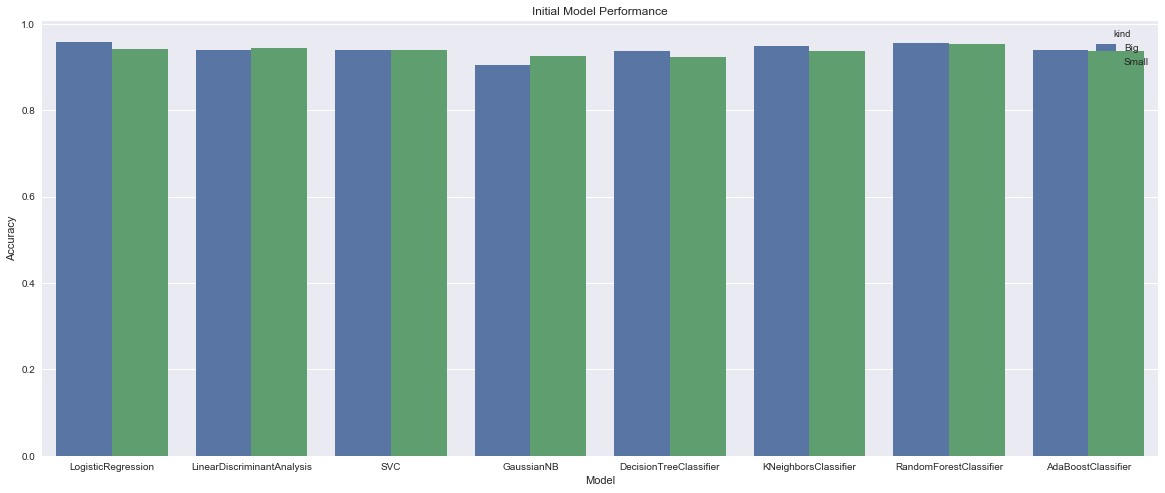

LogisticRegression ( Big ): 0.959
LinearDiscriminantAnalysis ( Big ): 0.94
SVC ( Big ): 0.94
GaussianNB ( Big ): 0.904
DecisionTreeClassifier ( Big ): 0.937
KNeighborsClassifier ( Big ): 0.948
RandomForestClassifier ( Big ): 0.956
AdaBoostClassifier ( Big ): 0.94
LogisticRegression ( Small ): 0.942
LinearDiscriminantAnalysis ( Small ): 0.945
SVC ( Small ): 0.94
GaussianNB ( Small ): 0.926
DecisionTreeClassifier ( Small ): 0.923
KNeighborsClassifier ( Small ): 0.937
RandomForestClassifier ( Small ): 0.953
AdaBoostClassifier ( Small ): 0.937


In [11]:
initialModeling(data, classes, initial_models, getAccuracy, 'Accuracy')

### Initial Precision

/Users/Liam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/Liam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


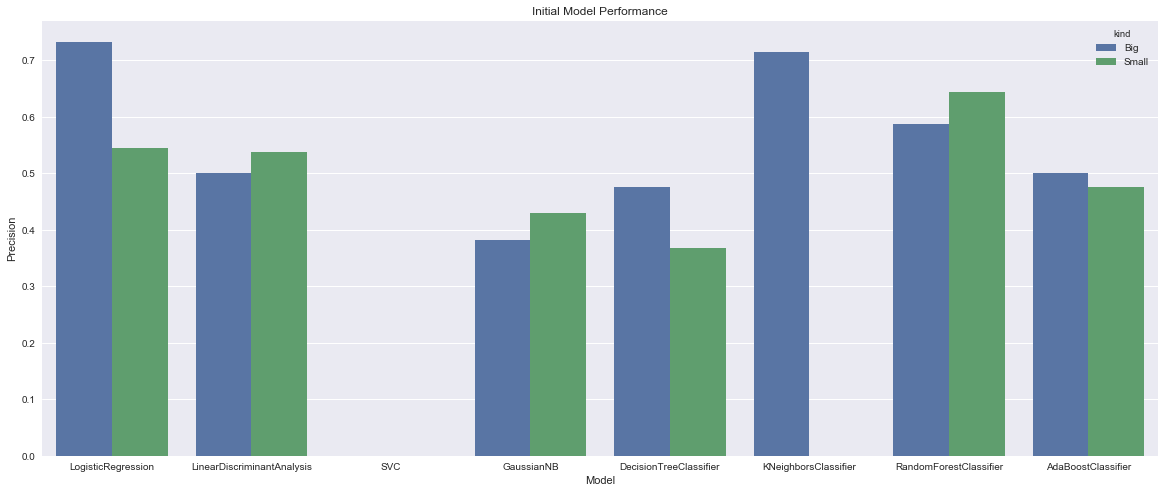

LogisticRegression ( Big ): 0.733
LinearDiscriminantAnalysis ( Big ): 0.5
SVC ( Big ): 0.0
GaussianNB ( Big ): 0.382
DecisionTreeClassifier ( Big ): 0.476
KNeighborsClassifier ( Big ): 0.714
RandomForestClassifier ( Big ): 0.588
AdaBoostClassifier ( Big ): 0.5
LogisticRegression ( Small ): 0.545
LinearDiscriminantAnalysis ( Small ): 0.538
SVC ( Small ): 0.0
GaussianNB ( Small ): 0.429
DecisionTreeClassifier ( Small ): 0.368
KNeighborsClassifier ( Small ): 0.0
RandomForestClassifier ( Small ): 0.643
AdaBoostClassifier ( Small ): 0.476


In [12]:
initialModeling(data, classes, initial_models, getPrecision, 'Precision')

### Initial TPR

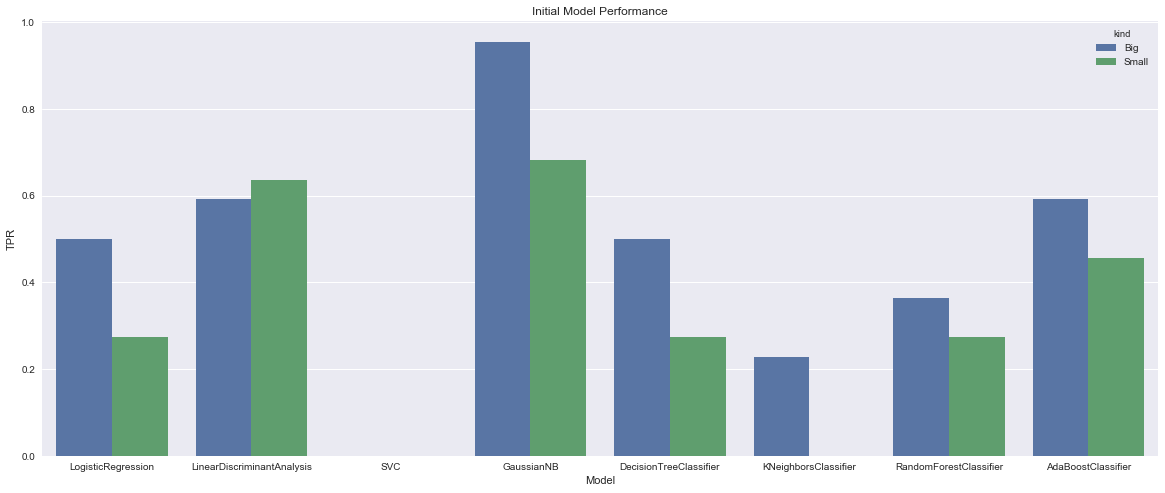

LogisticRegression ( Big ): 0.5
LinearDiscriminantAnalysis ( Big ): 0.591
SVC ( Big ): 0.0
GaussianNB ( Big ): 0.955
DecisionTreeClassifier ( Big ): 0.5
KNeighborsClassifier ( Big ): 0.227
RandomForestClassifier ( Big ): 0.364
AdaBoostClassifier ( Big ): 0.591
LogisticRegression ( Small ): 0.273
LinearDiscriminantAnalysis ( Small ): 0.636
SVC ( Small ): 0.0
GaussianNB ( Small ): 0.682
DecisionTreeClassifier ( Small ): 0.273
KNeighborsClassifier ( Small ): 0.0
RandomForestClassifier ( Small ): 0.273
AdaBoostClassifier ( Small ): 0.455


In [13]:
initialModeling(data, classes, initial_models, getTPR, 'TPR')

### Initial TNR

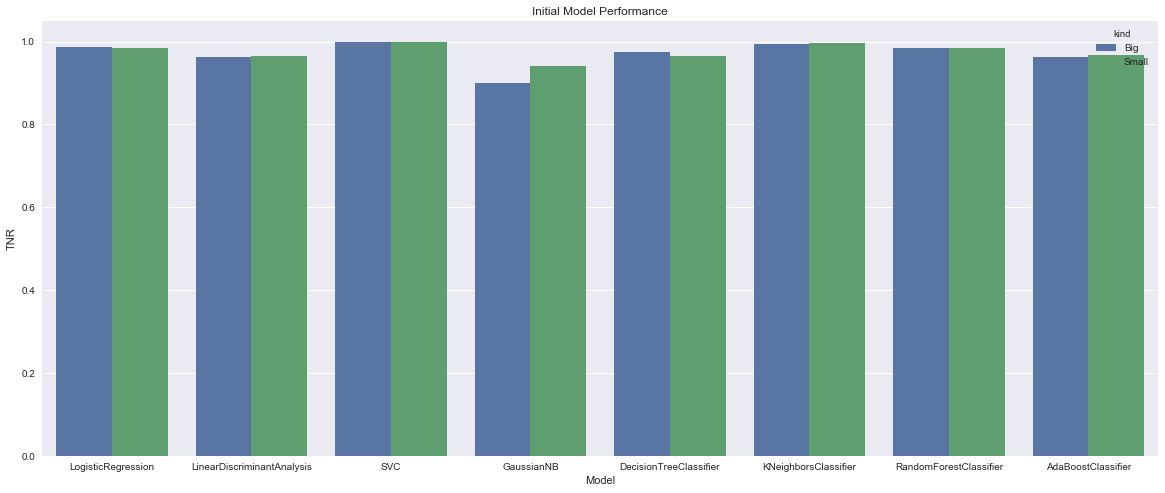

LogisticRegression ( Big ): 0.988
LinearDiscriminantAnalysis ( Big ): 0.962
SVC ( Big ): 1.0
GaussianNB ( Big ): 0.901
DecisionTreeClassifier ( Big ): 0.974
KNeighborsClassifier ( Big ): 0.994
RandomForestClassifier ( Big ): 0.985
AdaBoostClassifier ( Big ): 0.962
LogisticRegression ( Small ): 0.985
LinearDiscriminantAnalysis ( Small ): 0.965
SVC ( Small ): 1.0
GaussianNB ( Small ): 0.942
DecisionTreeClassifier ( Small ): 0.965
KNeighborsClassifier ( Small ): 0.997
RandomForestClassifier ( Small ): 0.985
AdaBoostClassifier ( Small ): 0.968


In [14]:
initialModeling(data, classes, initial_models, getTNR, 'TNR')

### Initial FNR

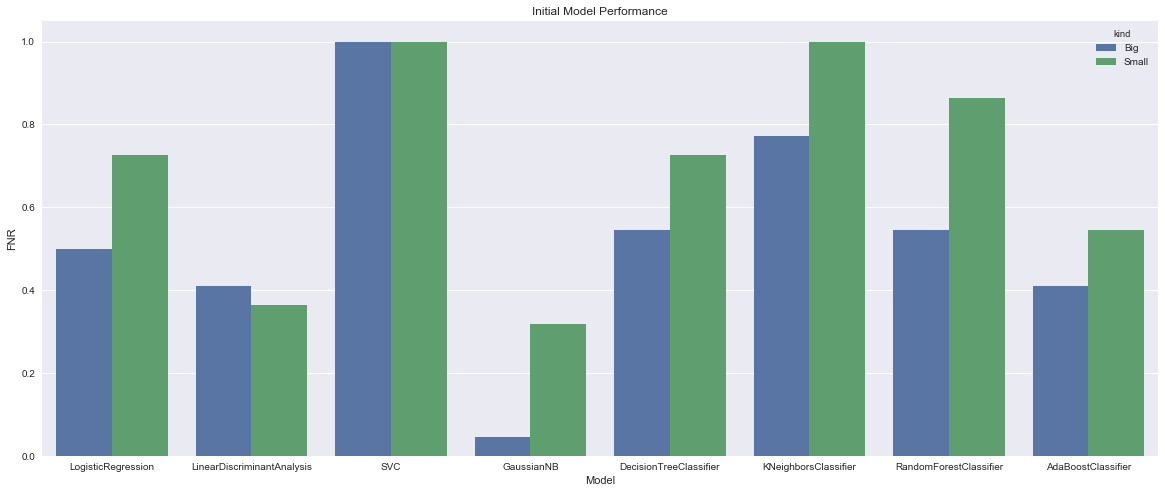

LogisticRegression ( Big ): 0.5
LinearDiscriminantAnalysis ( Big ): 0.409
SVC ( Big ): 1.0
GaussianNB ( Big ): 0.045
DecisionTreeClassifier ( Big ): 0.545
KNeighborsClassifier ( Big ): 0.773
RandomForestClassifier ( Big ): 0.545
AdaBoostClassifier ( Big ): 0.409
LogisticRegression ( Small ): 0.727
LinearDiscriminantAnalysis ( Small ): 0.364
SVC ( Small ): 1.0
GaussianNB ( Small ): 0.318
DecisionTreeClassifier ( Small ): 0.727
KNeighborsClassifier ( Small ): 1.0
RandomForestClassifier ( Small ): 0.864
AdaBoostClassifier ( Small ): 0.545


In [15]:
initialModeling(data, classes, initial_models, getFNR, 'FNR')

### Initial FPR

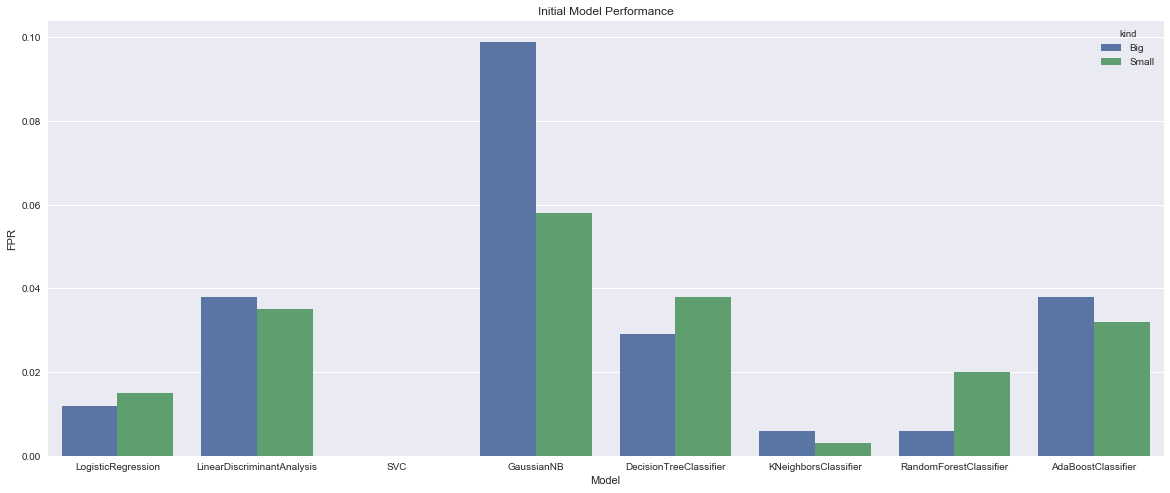

LogisticRegression ( Big ): 0.012
LinearDiscriminantAnalysis ( Big ): 0.038
SVC ( Big ): 0.0
GaussianNB ( Big ): 0.099
DecisionTreeClassifier ( Big ): 0.029
KNeighborsClassifier ( Big ): 0.006
RandomForestClassifier ( Big ): 0.006
AdaBoostClassifier ( Big ): 0.038
LogisticRegression ( Small ): 0.015
LinearDiscriminantAnalysis ( Small ): 0.035
SVC ( Small ): 0.0
GaussianNB ( Small ): 0.058
DecisionTreeClassifier ( Small ): 0.038
KNeighborsClassifier ( Small ): 0.003
RandomForestClassifier ( Small ): 0.02
AdaBoostClassifier ( Small ): 0.032


In [16]:
initialModeling(data, classes, initial_models, getFPR, 'FPR')

### Initial AUC

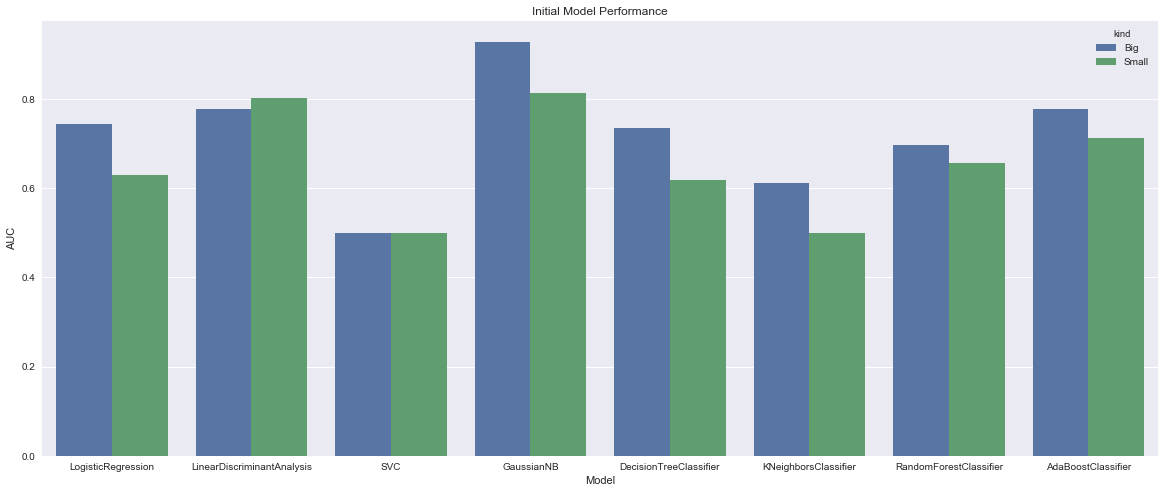

LogisticRegression ( Big ): 0.744
LinearDiscriminantAnalysis ( Big ): 0.776
SVC ( Big ): 0.5
GaussianNB ( Big ): 0.928
DecisionTreeClassifier ( Big ): 0.734
KNeighborsClassifier ( Big ): 0.611
RandomForestClassifier ( Big ): 0.697
AdaBoostClassifier ( Big ): 0.776
LogisticRegression ( Small ): 0.629
LinearDiscriminantAnalysis ( Small ): 0.801
SVC ( Small ): 0.5
GaussianNB ( Small ): 0.812
DecisionTreeClassifier ( Small ): 0.619
KNeighborsClassifier ( Small ): 0.499
RandomForestClassifier ( Small ): 0.656
AdaBoostClassifier ( Small ): 0.711


In [17]:
initialModeling(data, classes, initial_models, getAUC, 'AUC')

So this is a lot of information to take in. We don't neccisarily need to incorperate all of it into our decision. First, we need to identify what is important to us in this problem of all-star selection:

* **Accuracy** shouldn't matter too much us, especially since our baseline model's accuracy is nearly 95%.

* **Precision** shouldn't matter to us either, as long as we're placing an emphasis of the rate scores.

* **TPR** and **TNR** are essential. We want high scores for these. The **Naive Bayes** model has high scores for both, especially TPR.

* **FNR** and **FPR** are also important. They tell the other half of the story that TPR and TNR do. We want low scores for these. It's a toss up here.

Alltogether, it seems like **AUC** (Area under rock curve) is the best measure of performance for our purpose. We want to find an optimal balance betwenn precision and TPR (recall).

With this initial modeling data, we should move forward with a generative model,  an explanatory model, and an ensemble method. We'll clearly chose the amazingly effective **Naive Bayes** as our generative model. Next, we'll take good old **Logistic Regression** as our explanatory model. It appears to be one of the best all-around models, even though it does not blow everything else away in any given measure of performance. For the ensemble methods, it's between Random Forest and Adaptive Boosting. We'll go with **Adaptive Boosting** since it appears to be a bit more conservative and middle-of-the-road.

Additionally, we will only use our **data_big** dataset from here, since it cleary appears to do better than data_small.

In [18]:
X_train = X_big_train
y_train = y_big_train
X_test = X_big_test
y_test = y_big_test

## Model Tuning

### Naive Bayes
The **Naive Bayes** model works by using Bayes' Theorem and strong assumptions about independence between features. Gaussian Naive Bayes is the quintessential generative model, as it uses calculated sample means and variances as means of calulating the prior probability distributions it operates off of. In most cases, the assumptions made by the Naive Bayes are to....naive. However, it has shown to work very well with our dataset and the problem we're trying to solve.

Let's quickly compare the AUCROC scores of the Gaussian and Bernoulli models, just to make sure the Gaussian model is better:

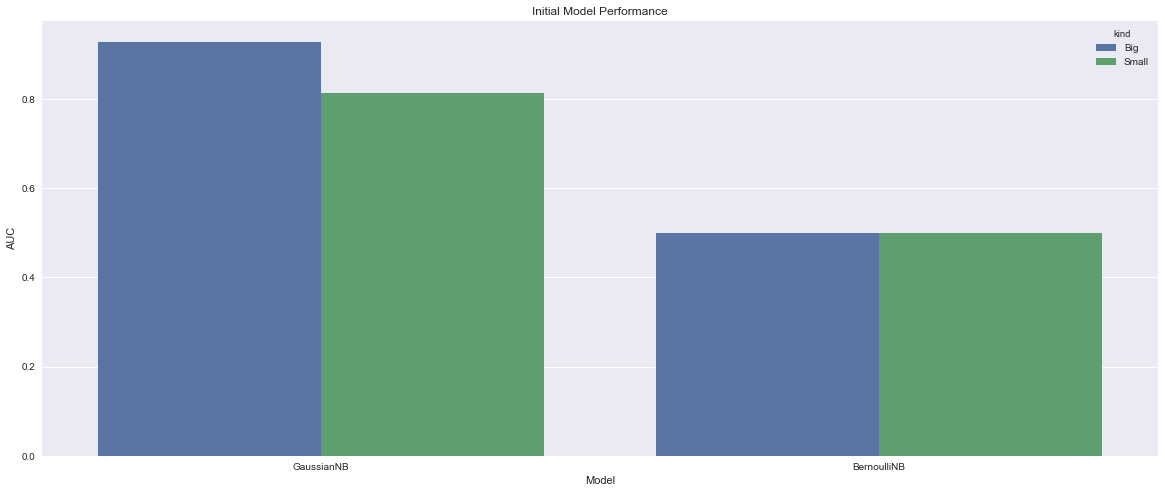

GaussianNB ( Big ): 0.928
BernoulliNB ( Big ): 0.5
GaussianNB ( Small ): 0.812
BernoulliNB ( Small ): 0.5


In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

initial_models = [GaussianNB, BernoulliNB]
classes = ['Big', 'Small']
initialModeling(data, classes, initial_models, getAUC, 'AUC')

The Gausssian model is, by far, better. 

And that's about all we can do for our Naive Bayes model. The only tunable parameter is the kernel, which can either be a Gaussian, Bernoulli, or Multinomial. We've shown that, for our purposes, Gaussian is better than Multinomial. And since we have some features with negative values, we cannot use a Multinomial kernel.

Let's examine the overall performance of our Gaussian Naive Bayes model:

In [20]:
nb = GaussianNB()
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)
classificationReport(y_test, pred_nb)

Accuracy =  0.904
Precision =  0.382
TPR =  0.955
TNR =  0.901
FNR =  0.045
FPR =  0.099
AUC =  0.928


Overall, our Naive Bayes model is a little liberal with its classifications (thus the precision score of 0.375), but it serves our purpose amazingly by providing an AUCROC score of 0.926.

Since we didn't get to tune our Naive Bayes model, lets tune a Logistic Regression model. This will provide us with a very explanatory model and allow us to do some cross-validation.

### Logistic Regression

We'll be using a **Stochastic Gradient Descent** algorithm to create our tuned logisitc regression model becuase it will allow us to utilize both L1 and L2 penalties (elastic net). The grid search takes about a minute to complete.

We'll use the **AUC** as our scoring metric:

In [33]:
from sklearn.linear_model import SGDClassifier

lr_tune = SGDClassifier(loss='log', penalty='elasticnet', max_iter=10)

alphas = list(np.logspace(-3, 2, 30))
l1_ratios = list(np.logspace(-3, 0, 30))
params = {'alpha':alphas, 'l1_ratio':l1_ratios}

clf_lr = GridSearchCV(lr_tune, params, scoring='roc_auc')
clf_lr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.001, 0.0014873521072935117, 0.0022122162910704502, 0.0032903445623126675, 0.0048939009184774942, 0.0072789538439831537, 0.010826367338740546, 0.016102620275609391, 0.023950266199874861, 0.03562247890262444, 0.0529831690628371, 0.078804628156699127, 0.11721022975334805, 0.1743...3823131979, 0.38566204211634725, 0.4893900918477494, 0.62101694189156165, 0.78804628156699119, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Let's plot the results of our cross-validation run:

/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


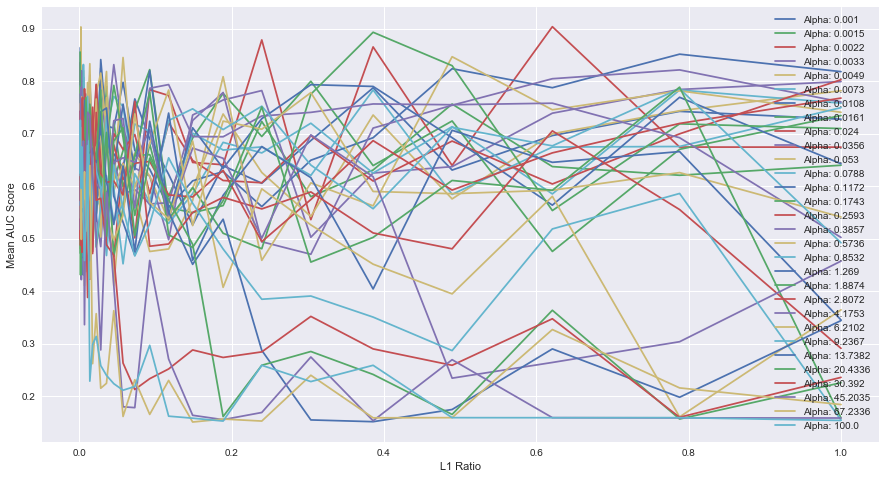

In [34]:
scores_lr = [x[1] for x in clf_lr.grid_scores_]
scores_lr = np.array(scores_lr).reshape(len(alphas), len(l1_ratios))

plt.figure(figsize=(15,8))

for ind, i in enumerate(alphas):
    plt.plot(l1_ratios, scores_lr[ind], label='Alpha: ' + str(round(i,4)))
plt.legend()
plt.xlabel('L1 Ratio')
plt.ylabel('Mean AUC Score')
plt.show()

In [35]:
params_lr = clf_lr.best_params_
alpha_lr = params_lr['alpha']
l1_ratio_lr = params_lr['l1_ratio']
print('Optimal Alpha Value: ', alpha_lr)
print('Optimal L1 Ratio: ', l1_ratio_lr)
print('Highest Mean ROC Score: ', clf_lr.best_score_)

Optimal Alpha Value:  0.00221221629107
Optimal L1 Ratio:  0.621016941892
Highest Mean ROC Score:  0.903853056032


Now lets see how this new model performs:

In [47]:
lr_tuned = SGDClassifier(loss='log', penalty='elasticnet', alpha=alpha_lr, l1_ratio=l1_ratio_lr, max_iter=10)
lr_tuned.fit(X_train, y_train)
pred_lr_tuned = lr_tuned.predict(X_test)
classificationReport(y_test, pred_lr_tuned)

Accuracy =  0.915
Precision =  0.378
TPR =  0.636
TNR =  0.933
FNR =  0.364
FPR =  0.067
AUC =  0.785


In [48]:
lr_coef = lr_tuned.coef_.tolist()[0]
df_lr = pd.DataFrame()
df_lr['Features'] = pd.Series(X_train.columns.tolist())
df_lr['Coefficients'] = pd.Series(lr_coef)
df_lr

,Features,Coefficients
0,Age,-396.648782
1,G,-776.236244
2,GS,404.164523
3,MP,-139.561958
4,3PAr,-3.253747
5,FTr,-4.223931
6,AST%,-148.058616
7,STL%,-18.933887
8,BLK%,-8.518646
9,TOV%,-276.225729


Here we can see how specific features affect are considered by the model. A higher age seems to lead to a lesser chance of being an all-star. FTA (Free Throw Attempts) seems to be a very strong predictor of all-star selection. The best players do seem to get fouled the most, so it makes sense.

Now that we have some interpretability, lets move onto tuning our Adaptive Boost model.

### Adaptive Boost

Adaptive Boost, or **AdaBoost** is a gradient-boosted algorithm that can use any one of an assortment of other models as its base. It's one of the most robust ensemble methods. Let's try tuning a robust version of it.
* We'll try our Naive Bayes and tuned Logistic Regression models, along with Random Forrest, as the basis of AdaBoost

In [49]:
ab_tune = AB()

mod1 = lr_tuned
mod2 = GaussianNB()
mod3 = RF()
mods = VotingClassifier(estimators=[('lr', mod1), ('gnb', mod2), ('rf', mod3)], voting='soft')
rf_n_estimators = [10, 50, 100, 200, 300, 400, 500]
params = {'rf__n_estimators': rf_n_estimators}
                                 
clf_ab = GridSearchCV(estimator=mods, param_grid=params, scoring='roc_auc')
clf_ab.fit(X_train, y_train)

/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow enco

GridSearchCV(cv=None, error_score='raise',
       estimator=VotingClassifier(estimators=[('lr', SGDClassifier(alpha=0.0022122162910704502, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.62101694189156165, learning_rate='optimal', loss='log',
       max_iter=10, n_iter=None, n_jobs=1, penalty='e...        warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'rf__n_estimators': [10, 50, 100, 200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

The runtime warning from the cell above doesn't have an effect on the purposes for which we're using the model. It can be safely ignored.

In [50]:
params_ab = clf_ab.best_params_
n_estimators_ab = params_ab['rf__n_estimators']
print('Optimal RF Estimator Count: ', n_estimators_ab)
print('Highest Mean ROC Score: ', clf_lr.best_score_)

Optimal RF Estimator Count:  400
Highest Mean ROC Score:  0.903853056032


Now lets see how this new model performs:

In [51]:
ab_tuned = clf_ab
pred_ab_tuned = ab_tuned.predict(X_test)
classificationReport(y_test, pred_ab_tuned)

Accuracy =  0.962
Precision =  0.75
TPR =  0.545
TNR =  0.988
FNR =  0.455
FPR =  0.012
AUC =  0.767


/Users/Liam/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


While this tuned Adaptive Boost model excels in metrics such as TNR and accuracy, it still doesn't beat the Naive Bayes model's AUCROC score.

## Deep Learning
Let's see if a simple neural network is effective here, even though I doubt it will be due to our relatively small dataset. Nevertheless, this is always fun to try.

In [52]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras import backend
backend.set_image_dim_ordering('th')

Using TensorFlow backend.


We need to convert our data to a NumPy matrix representation:

In [53]:
X_train_nn = X_train.as_matrix()
X_test_nn = X_test.as_matrix()

y_train_nn = np_utils.to_categorical(y_train)
y_test_nn = np_utils.to_categorical(y_test)

y_train_nn.shape

(1455, 2)

Here is a very simple neural network:

In [54]:
def basicNN():
    model = Sequential()
    model.add(Dense(24, input_dim=24, init='normal', activation='relu'))
    model.add(Dense(1, init='normal', activation='softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

Now let's implement it:

In [55]:
basic_nn = basicNN()

basic_nn.fit(X_train_nn, y_train, nb_epoch=10, batch_size=200, verbose=2)

nn_results = basic_nn.evaluate(X_test_nn, y_test, verbose=0)
print('')
print('Neural Network accuracy: ', nn_results[1])

/Users/Liam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, input_dim=24, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Liam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="softmax", kernel_initializer="normal")`
  after removing the cwd from sys.path.
/Users/Liam/anaconda/lib/python3.6/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 2/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 3/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 4/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 5/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 6/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 7/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 8/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 9/10
0s - loss: 15.0658 - acc: 0.0550
Epoch 10/10
0s - loss: 15.0658 - acc: 0.0550

Neural Network accuracy:  0.0604395604396


And as expected, performance is pitiful.

## Final Model

Since we've identified having that optimal balance between precision and recall is our main desire when predicting NBA all-stars, our metric of concern ir **Area Under ROC**. With this, the Gaussian Naive Bayes model is the best one for our purpose. It achieved the highest AUROC score of 0.928. While other models may have had superior accuracy, recall, or specificity, the Navie Bayes model delivered where it matters. 

Here, again, are the performance metrics from that model:

In [34]:
classificationReport(y_test, pred_nb)

Accuracy =  0.904
Precision =  0.382
TPR =  0.955
TNR =  0.901
FNR =  0.045
FPR =  0.099
AUC =  0.928
